In [1]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from collections import namedtuple

## Not Cover(TO DO)
 - future, random, episode Strategy
 - DDPG
 - Robot manipulation

In [2]:
class BitFilpEnv(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}

    def __init__(self, n=20, max_steps=None, e=0.5):
        super(BitFilpEnv, self).__init__()
        self.n = n # length of bit
        # self.e = e # error rate of goal
        
        if max_steps is None:
            self.max_steps = n
        else:
            self.max_steps = max_steps      

        self.observation_space = spaces.Dict({
            'state': spaces.Box(low=0, high=1, shape=(n, )),
            'goal': spaces.Box(low=0, high=1, shape=(n, )),
        })
        self.action_space = spaces.Discrete(n)
        self.reset()

    def step(self, action):
        # action is an integer type in range [0, self.bit_length)
        self.steps += 1
        self.state = np.copy(self.state)
        self.state[action] = self.state[action] ^ 1
        return (self.get_obs(), self.reward(), self.terminate(), None)

    def reset(self):
        # every episode has different goal
        self.steps = 0
        self.state = np.random.randint(2, size = self.n)
        self.goal = np.random.randint(2, size = self.n)

        while (self.state == self.goal).all(): # if goal is same as state, must change.
            self.goal = np.random.randint(2, size = self.n)

        return self.get_obs()

    def get_obs(self):
        return {
            'state': self.state,
            'goal': self.goal
        }

    def terminate(self):
        return (self.state == self.goal).all() or self.steps >= self.max_steps
    
    def reward(self, state=None, action=None, goal=None):
        if goal is not None:
            state_ = np.copy(state)
            state_[action] = state_[action] ^ 1
            return 0 if np.array_equal(state_, goal) else -1

        return 0 if np.array_equal(self.state, self.goal) else -1

    def render(self, mode='human'):
        print("State: {}".format(self.state))
        print("Goal : {}\n".format(self.goal))

    def close(self):
        pass

In [3]:
class ReplayMemory(object):
    
    def __init__(self, capacity = 1e5):
        self.capacity = capacity
        self.memory = []
        self.cursor = 0
    
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.cursor] = Transition(*args)
        self.cursor = int((self.cursor + 1) % self.capacity)

    def sample(self, batch_size):
        """
        Returns batch_size number of samples from the replay memory
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class DQN_HER(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN_HER, self).__init__()
        self.state_space = input_dim
        self.action_space = output_dim
        self.epsilon = 0.1

        self.fc1 = nn.Linear(self.state_space, 256)
        self.fc2 = nn.Linear(256, self.action_space)

        self.steps_done = 0
        self.eps_threshold = 0
    
    def forward(self, x):
        # print("x1",x)
        x = F.relu(self.fc1(x))
        # print("x2",x.shape)
        # x = F.softmax(self.fc2(x), dim=-1)
        x = self.fc2(x)
        # x = F.relu(self.fc2(x))
        # print("x3",x.shape)
        return x

    def act(self, state, goal):
        """
            decaying e-greedy
        """
        self.eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1

        if np.random.random() > self.eps_threshold:
            with torch.no_grad():
                concat_state_goal = np.concatenate([state, goal]) # e.g [1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1]
                s = torch.tensor([concat_state_goal], dtype=torch.float32).to(device) # e.g s = tensor([[0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1.]])
                action = self.forward(s).argmax().item() # action = 0 ~ 7
        else:
            action = np.random.choice(self.action_space)
        return action


In [5]:
def Strategy(episode_trajectory, t, k, strategy='final', memory = None):
    """
        final : the final state of the environment
        future : replay k random states which come from the same episode as the transition being replayed and were observed after it
        episode : replay k random states coming from the same episode as the transition being replayed
        random : replay k random states encountered so far in the whole training procedure
    """
    G = []
    if strategy == 'final':
        G.append(episode_trajectory[-1])
        return G
    # elif strategy == 'future':
    #     for i in range(k):
    #         future_index = np.random.randint(t,t+k)
    #         if future_index >= len(episode_trajectory):
    #             future_index = len(episode_trajectory)-1 # indicate last state
    #         G.append(episode_trajectory[future_index])
    #     return G
    # elif strategy == 'episode':
    #     for i in range(k):
    #         episode_index = np.random.randint(len(episode_trajectory))
    #         G.append(episode_trajectory[episode_index])
    #     return G
    # elif strategy == 'random':
    #     for i in range(k):
    #         random_index = np.random.randint(len(memory))
    #         G.append(memory.memory[random_index][0][:8]) # random transition's state in replay memory
    #     return G

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE) # [Transition(...), Transition(...), ...]
    batch = Transition(*zip(*transitions)) # Transition(state=(BATCH_SIZE*array([0,...,1])), action=(BATCH_SIZE * 0 or 1) ...)

    state_batch = torch.tensor(batch.state, dtype=torch.float32, device=device) #not dtype float64 or int*. only float32..
    action_batch = torch.tensor(batch.action, device=device).unsqueeze(-1) # make batch
    reward_batch = torch.tensor(batch.reward, device=device).unsqueeze(-1) # make batch
    next_state_batch = torch.tensor(batch.next_state, dtype=torch.float32, device=device)
    done_mask_batch = torch.tensor([not s for s in batch.done], device=device).unsqueeze(-1) # make batch

    Q_s = policy_net(state_batch).gather(1, action_batch)
    # print("q",Q_s)
    #t.max(1)[0] will return largest column value of each row. [1] = indices
    max_Q_s_prime = target_net(next_state_batch).max(1)[0].detach().unsqueeze(-1) # target_net dosen't update by Backprop.
    # print("rb", reward_batch)
    # print("max",max_Q_s_prime)

    target = reward_batch + GAMMA * done_mask_batch * max_Q_s_prime
    # print("target", target)

    loss = F.smooth_l1_loss(Q_s, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

In [7]:
strategy_list = ['final', 'future', 'episode', 'random']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
env = BitFilpEnv()
Transition = namedtuple('Transition', 
                       ('state', 'action', 'reward', 'next_state', 'done'))

#### HYPER PARAMETER ####
MEMORY_SIZE = 1e6
BATCH_SIZE = 64 # n이 증가할때마다 배치수도 같이 늘려줘야함.
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

TARGET_UPDATE = 50 # DQN. target_net update period

N = 10 # How many update policy_net in 1 episode
STRATEGY = strategy_list[0]
K = 5 # ratio of HER data in replay buffer
M = 10000 # how many episode
T = env.n # max step in one episode
#########################
PLOT_PERIOD = 100

memory = ReplayMemory(MEMORY_SIZE)
policy_net = DQN_HER(env.n*2, env.n).to(device) # why *2 : input is state + goal
target_net = DQN_HER(env.n*2, env.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters())

strategy_list = ['final', 'future', 'episode', 'random']
success = 0
success_rate_list = []

for i_episode in range(1,M+1): 
    state_trajectory = []
    action_trajectory = []

    # Sample a goal g and initial state s_0
    obs = env.reset()
    state = obs['state']
    goal = obs['goal']
    done = False

    for t in range(T):
        if not done:
            action = policy_net.act(state, goal)
            state_trajectory.append(state)
            action_trajectory.append(action)
            next_state, reward, done, info = env.step(action)

            # push standard goal transition
            memory.push(np.concatenate([state, goal]), action, reward, np.concatenate([next_state['state'], goal]), done)
            state = next_state['state']

            if done:
                if reward == 0:
                    success += 1
                state_trajectory.append(state) ## add final state
    
    for t in range(len(action_trajectory)): # not T, but len(action_trajectory). because episode_length is not fixed at T
        # sample a set of addition golas
        # G = Strategy(state_trajectory, T, K, STRATEGY, memory)
        g_prime = state_trajectory[-1] # final state
        r_prime = env.reward(state_trajectory[t], action_trajectory[t], g_prime)
        done = False #True if r_prime == 0 else False
        memory.push(np.concatenate([state_trajectory[t], g_prime]), action_trajectory[t], r_prime, np.concatenate([state_trajectory[t+1], g_prime]), done)

    for t in range(N):
        optimize_model()
    
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    if i_episode % PLOT_PERIOD == 0:
        print(f"i_episode : {i_episode}, success_rate : {success / PLOT_PERIOD}")
        success_rate_list.append(success / PLOT_PERIOD)
        success = 0



i_episode : 100, success_rate : 0.0
i_episode : 200, success_rate : 0.0
i_episode : 300, success_rate : 0.0
i_episode : 400, success_rate : 0.0
i_episode : 500, success_rate : 0.0
i_episode : 600, success_rate : 0.0
i_episode : 700, success_rate : 0.0
i_episode : 800, success_rate : 0.0
i_episode : 900, success_rate : 0.0
i_episode : 1000, success_rate : 0.0
i_episode : 1100, success_rate : 0.03
i_episode : 1200, success_rate : 0.03
i_episode : 1300, success_rate : 0.04
i_episode : 1400, success_rate : 0.04
i_episode : 1500, success_rate : 0.11
i_episode : 1600, success_rate : 0.15
i_episode : 1700, success_rate : 0.25
i_episode : 1800, success_rate : 0.26
i_episode : 1900, success_rate : 0.23
i_episode : 2000, success_rate : 0.42
i_episode : 2100, success_rate : 0.54
i_episode : 2200, success_rate : 0.54
i_episode : 2300, success_rate : 0.65
i_episode : 2400, success_rate : 0.69
i_episode : 2500, success_rate : 0.8
i_episode : 2600, success_rate : 0.77
i_episode : 2700, success_rate :

KeyboardInterrupt: 

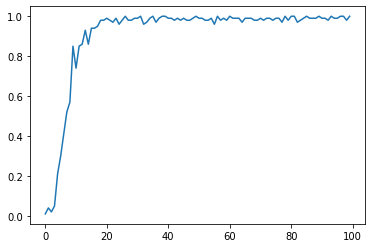

In [213]:
plt.plot(success_rate_list)